In [3]:
"""Evaluates feature attributes of a adversarialy trained model against adv attack"""
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from datetime import datetime
import json
import math
import os
import sys
import time

import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

import PIL
import matplotlib.pyplot as plt
from numpy import linalg as LA
import numpy as np

from model import Model

from tensorflow.python import pywrap_tensorflow
from tensorflow.python.ops.parallel_for.gradients import jacobian


In [4]:
model_dir = "./models/nat"

num_eval_examples = 10000
eval_batch_size = 200


In [5]:
tf.reset_default_graph()
x = tf.placeholder(tf.float32, shape = [None, 784])
y = tf.placeholder(tf.int64, shape = [None])
model = Model()
model.build_and_eval(x, y)

checkpoint = tf.train.latest_checkpoint(model_dir)
reader=pywrap_tensorflow.NewCheckpointReader(checkpoint)
saver = tf.train.Saver()

Instructions for updating:
Colocations handled automatically by placer.


In [6]:
config = tf.ConfigProto()
config.log_device_placement=False
config.allow_soft_placement=True
config.gpu_options.allow_growth=True

session = tf.Session(config=config)
session.run(tf.global_variables_initializer())
saver.restore(session, checkpoint)

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./models/nat/checkpoint-7800


In [16]:
test_path = "./adv_test/jsma/adv.npy"
adv_test = np.load(test_path)

mnist = input_data.read_data_sets('MNIST_data', one_hot=False)
true_labels = mnist.test.labels

# train_total_data = np.column_stack((adv_test,true_labels))

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


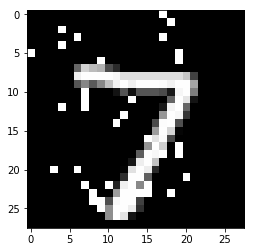

In [17]:
plt.imshow(np.resize(adv_test[0],[28,28]), cmap='Greys_r')

In [18]:


num_batches = int(math.ceil(num_eval_examples / eval_batch_size))
total_xent_nat = 0.
total_xent_adv = 0.
total_corr_nat = 0
total_corr_adv = 0


for ibatch in range(num_batches):
    bstart = ibatch * eval_batch_size
    bend = min(bstart + eval_batch_size, num_eval_examples)

#     x_batch = adv_test[bstart:bend, :]
#     y_batch = true_labels[bstart:bend]

    x_batch = adv_test[bstart:bend, :]
    y_batch = mnist.test.labels[bstart:bend]

    dict_nat = {model.x_input: x_batch, model.y_input: y_batch}

#     x_batch_adv = attack.perturb(x_batch, y_batch, sess)
#     dict_adv = {model.x_input: x_batch_adv, model.y_input: y_batch}

    cur_corr_nat, cur_xent_nat = session.run([model.num_correct, model.xent], feed_dict = dict_nat)
    
    total_xent_nat += cur_xent_nat
    total_corr_nat += cur_corr_nat
    
#     total_xent_adv += cur_xent_adv
#     total_corr_adv += cur_corr_adv
    
avg_xent_nat = total_xent_nat / num_eval_examples
avg_xent_adv = total_xent_adv / num_eval_examples
acc_nat = total_corr_nat / num_eval_examples
acc_adv = total_corr_adv / num_eval_examples

print('natural: {:.2f}%'.format(100 * acc_nat))
print('adversarial: {:.2f}%'.format(100 * acc_adv))
print('avg nat loss: {:.4f}'.format(avg_xent_nat))
print('avg adv loss: {:.4f}'.format(avg_xent_adv))
    
#     cur_corr_adv, cur_xent_adv = sess.run(
#     [model.num_correct,model.xent],
#     feed_dict = dict_adv)

natural: 1.58%
adversarial: 0.00%
avg nat loss: 1.5555
avg adv loss: 0.0000
